# Color Any Map With Only 4 Colors (and Logical Programming) #
#### Ann Arbor Scientific and Technical Computing, November 24th 2020
#### Presented by David Perner
<img src="img/1200px-Four_Colour_Map_Example.svg.png" style="width:500px"></img>

## Four color theorem ##

Although surprisingly not all that useful to cartographers, the four color theorem states, more or less, that four colors are all that are needed to color in any map. A [more formal definition](https://en.wikipedia.org/wiki/Four_color_theorem#Precise_formulation_of_the_theorem) would be:

>"given any separation of a plane into contiguous regions, the regions can be colored using at most four colors so that no two adjacent regions have the same color"

Which requires some additional explanation. 
- Adjacency is based on regions that share edges, not corners. So in this definition, Colorado and Arizona are not adjacent, but Colorado and Utah are.
- More practically for maps, countries often have non-contiguous regions (for instance, Alaska). Since this breaks the adjacency condition of the theorem, there may be real life maps that would require 5 or 6 colors.

However, we will be looking at relatively simple boundaries, so the contiguous problem shouldn't be an issue.

It should also be noted that despite its seeming simplicity, the four color theorem wasn't proven decisively until about 1989.

## Logical Programming ##

So there are probably three programming paradigms people are familiar with, or have at least heard of. These would be:
- Procedural (such as C or Fortran, where data is evaluated in a step-by-step manner)
- Object-oriented (such as Java or C++, where objects are used to encapsulate data and methods)
- Functional (such as Haskell or Scala, which eschew the idea of mutable state and view programs as mathematical evaluations)

Each of these has its pros and cons, and tasks they are better suited for. Where logical programming comes in is when we want to show how variables are logically connected, define what types of relationships exist and then ask which solutions are valid. To start off, we'll show a relatively simple example of familial relationships. 

For more information comparing and contrasting different programming paradigms, I recommend this [excellent presentation by Aja Hammerly](https://youtu.be/cgVVZMfLjEI)

In [1]:
using Julog

┌ Info: Precompiling Julog [5d8bcb5e-2b2c-4a96-a2b1-d40b3d3c344f]
└ @ Base loading.jl:1278


So to start, we'll define a small family tree. While there are dedicated logical languages like `Prolog`, for this presentation we'll be using the `Julog` package since I'm more familiar with the `Julia` ecosystem. The first line would read, for example, as "the parent of tom is bob". The `<<=true` indicates that we are asserting that this is true instead of asking if it is. Together, these assertions are "clauses".

In [2]:
clauses = @julog [
    parent(tom, bob) <<= true,
    parent(pam, bob) <<= true,
    parent(tom, liz) <<= true,
    parent(bob, ann) <<= true,
    parent(bob, pat) <<= true,
    parent(pat, jim) <<= true
]

6-element Array{Clause,1}:
 parent(tom, bob)
 parent(pam, bob)
 parent(tom, liz)
 parent(bob, ann)
 parent(bob, pat)
 parent(pat, jim)

We can then start querying these relationships. We can set a "goal" of asking (there's no assertion here) if bob is the parent of pat, which we see is true. However, liz is not pat's parent. 

In [3]:
goal = @julog parent(bob, pat)

resolve(goal, clauses)

(true, Any[{}])

In [4]:
goal = @julog parent(liz, pat)

resolve(goal, clauses)

(false, Any[])

A carry over in `Julog` from the `Prolog` it's based on is the use of lower case names to indicate constants and upper case names to indicate variables. This is why all the names have been lower case so far. However, what if we want to ask who liz's parents are? For that, we can use a variable in the first argument of `parent` and have the goal resolved.

Similarly, we can ask who bob's children are, and who all the parent/child pairs are.

In [5]:
goal = @julog parent(X, liz)

resolve(goal, clauses)

(true, Any[{X => tom}])

In [6]:
goal = @julog parent(bob, X)

resolve(goal, clauses)

(true, Any[{X => ann}, {X => pat}])

In [7]:
goal = @julog parent(X, Y)

resolve(goal, clauses)

(true, Any[{X => tom, Y => bob}, {X => pam, Y => bob}, {X => tom, Y => liz}, {X => bob, Y => ann}, {X => bob, Y => pat}, {X => pat, Y => jim}])

But suppose we want to express a more complicated relationship. Below is how we would asking about ancestors of individuals. So the way this reads is that `ancestor` will check if two individuals share the parent/child relationship. If they don't, it searches for another individual who can bridge that relationship, and because `ancestor` is defined recursively, it can string together any number of intermediate individuals. It will also find all individuals who can share this relationship, so both parents, all four grandparents, etc.

In [8]:
ancestor_rule_set = @julog [
    ancestor(X,Y)<<=parent(X,Y),
    ancestor(X,Z)<<=parent(X,Y)&ancestor(Y,Z)
]

2-element Array{Clause,1}:
 ancestor(X, Y) <<= parent(X, Y)
 ancestor(X, Z) <<= parent(X, Y) & ancestor(Y, Z)

In [10]:
clauses2=vcat(clauses, ancestor_rule_set)

goal = @julog ancestor(pam, X)

resolve(goal, clauses2)

(true, Any[{X => bob}, {X => ann}, {X => pat}, {X => jim}])

Now that we've seen how logical programming works for the familial example, let's move on to how we'd use it to color a map. First, we want to create a set of clauses that define which colors can be next to one another

In [11]:
color_pairs = @julog [
    n(red, green)<<=true,
    n(green, red)<<=true,
    n(blue, red)<<=true,
    n(yellow, red)<<=true,
    n(red, blue)<<=true,
    n(green, blue)<<=true,
    n(blue, green)<<=true,
    n(yellow, green)<<=true,
    n(red, yellow)<<=true,
    n(green, yellow)<<=true,
    n(blue, yellow)<<=true,
    n(yellow, blue)<<=true
]

12-element Array{Clause,1}:
 n(red, green)
 n(green, red)
 n(blue, red)
 n(yellow, red)
 n(red, blue)
 n(green, blue)
 n(blue, green)
 n(yellow, green)
 n(red, yellow)
 n(green, yellow)
 n(blue, yellow)
 n(yellow, blue)

Next, we define a function `colors` that has as input all the states were currently trying to find colors for and try to assign the color constants we just defined to each pair. The function will only be true when each state has a color that satisfies the earlier clauses

In [93]:
map_layout = @julog colors(IA, IL, IN, KS, KY, MI, MN, MO, ND, NE, OH, SD, WI)<<=
    n(IL, IA) & n(IL, IN) & n(IL, KY) & n(IL, MO) & n(IL, WI) &
    n(IN, MI) & n(IN, OH) & n(IN, KY) &
    n(IA, MN) & n(IA, MO) & n(IA, NE) & n(IA, SD) & n(IA, WI) &
    n(KS, MO) & n(KS, NE) & 
    n(MI, OH) & n(MI, MN) & n(MI, WI) &
    n(MN, ND) & n(MN, SD) & n(MN, WI) &
    n(MO, NE) & n(MO, KY) &
    n(NE, SD) &
    n(ND, SD) &
    n(OH, KY)

colors(IA, IL, IN, KS, KY, MI, MN, MO, ND, NE, OH, SD, WI) <<= n(IL, IA) & n(IL, IN) & n(IL, KY) & n(IL, MO) & n(IL, WI) & n(IN, MI) & n(IN, OH) & n(IN, KY) & n(IA, MN) & n(IA, MO) & n(IA, NE) & n(IA, SD) & n(IA, WI) & n(KS, MO) & n(KS, NE) & n(MI, OH) & n(MI, MN) & n(MI, WI) & n(MN, ND) & n(MN, SD) & n(MN, WI) & n(MO, NE) & n(MO, KY) & n(NE, SD) & n(ND, SD) & n(OH, KY)

While it looks very similar to the function definition, here we call `colors` with no definition to mean we want to know which colors satisfy the expression

In [99]:
goal = @julog colors(IA, IL, IN, KS, KY, MI, MN, MO, ND, NE, OH, SD, WI)
map_soln = resolve(goal, vcat(color_pairs, map_layout))

(true, Any[{ND => yellow, SD => green, IN => blue, WI => green, NE => yellow, KY => green, MN => red, KS => blue, IA => blue, OH => red, MI => yellow, IL => yellow, MO => red}, {ND => blue, SD => green, IN => blue, WI => green, NE => yellow, KY => green, MN => red, KS => blue, IA => blue, OH => red, MI => yellow, IL => yellow, MO => red}, {ND => yellow, SD => green, IN => blue, WI => green, NE => yellow, KY => green, MN => red, KS => green, IA => blue, OH => red, MI => yellow, IL => yellow, MO => red}, {ND => blue, SD => green, IN => blue, WI => green, NE => yellow, KY => green, MN => red, KS => green, IA => blue, OH => red, MI => yellow, IL => yellow, MO => red}, {ND => blue, SD => yellow, IN => blue, WI => green, NE => green, KY => green, MN => red, KS => yellow, IA => blue, OH => red, MI => yellow, IL => yellow, MO => red}, {ND => green, SD => yellow, IN => blue, WI => green, NE => green, KY => green, MN => red, KS => yellow, IA => blue, OH => red, MI => yellow, IL => yellow, MO => 

`Julog` has gone through and found every valid color combination for this subset of the US map. How many, you may ask?

In [111]:
length(map_soln[2])

9216

That's quite a few. Let's see what they look like

In [105]:
using Plots, LibGEOS, GeoJSON, Random, StatsBase

Fortunately, there's an online repo for US state geographic data (in reality I'm sure there are many, but at least this is the one I'm using)

In [98]:
states = download("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

states_geo = GeoJSON.parse(read(states, String));

The dictionary here is necessary to translate between the GeoJSON data and the `Julog` results. The `Var` expressions are a `Julog` data type

In [112]:
state_abbr = Dict(
    "Iowa" => Var(:IA),
    "Illinois" => Var(:IL),
    "Indiana" => Var(:IN),
    "Kansas" => Var(:KS),
    "Kentucky" => Var(:KY),
    "Michigan" => Var(:MI),
    "Minnesota" => Var(:MN),
    "Missouri" => Var(:MO),
    "North Dakota" => Var(:ND),
    "Nebraska" => Var(:NE),
    "Ohio" => Var(:OH),
    "South Dakota" => Var(:SD),
    "Wisconsin" => Var(:WI)
)

Dict{String,Var} with 13 entries:
  "Nebraska"     => NE
  "Illinois"     => IL
  "Missouri"     => MO
  "Kansas"       => KS
  "Michigan"     => MI
  "North Dakota" => ND
  "Iowa"         => IA
  "Minnesota"    => MN
  "South Dakota" => SD
  "Kentucky"     => KY
  "Indiana"      => IN
  "Wisconsin"    => WI
  "Ohio"         => OH

While we could use the names "red", "green", "blue", and "yellow" to define the map colors, I wanted something with greater odds of being color-blind friendly, so the colors below were chosen from a [color-blind palate](http://mkweb.bcgsc.ca/colorblind/palettes.mhtml#page-container).

In [85]:
colors = Dict(
    Const(:red) => colorant"#5A000F",
    Const(:green) => colorant"#007702",
    Const(:yellow) => colorant"#FF6E3A",
    Const(:blue) => colorant"#7CFFFA"
)

Dict{Const,RGB{FixedPointNumbers.Normed{UInt8,8}}} with 4 entries:
  red    => RGB{N0f8}(0.353,0.0,0.059)
  yellow => RGB{N0f8}(1.0,0.431,0.227)
  green  => RGB{N0f8}(0.0,0.467,0.008)
  blue   => RGB{N0f8}(0.486,1.0,0.98)

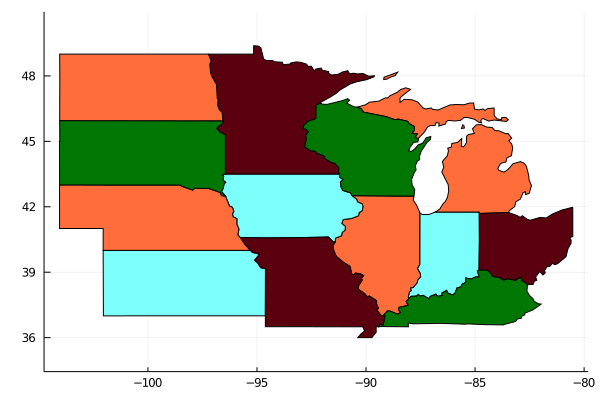

In [113]:
pout = plot()
for state in states_geo.features
    if state.properties["name"] in keys(state_abbr)
        abbr = state_abbr[state.properties["name"]]
        base_color = map_soln[2][1][abbr]
        state_color = colors[base_color]
        plot!(pout,state.geometry, color=state_color)
    end
end
pout

However, as we saw before, there are over nine thousand possible solutions to this problem. What do some of the other ones look like?

┌ Info: Saved animation to 
│   fn = /Users/crashburnrepeat/AASTC/November 2020/img/state_soln.gif
└ @ Plots /Users/crashburnrepeat/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/crashburnrepeat/AASTC/November 2020/img/state_soln.gif")
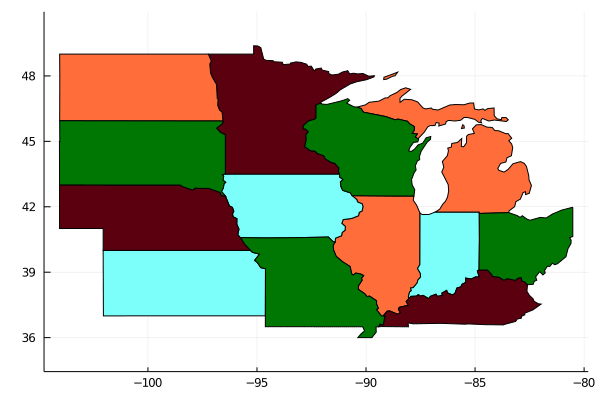

In [117]:
anim = @animate for i in sample(shuffle(range(1, length(map_soln[2]), step=1)), 100)
    pout = plot()
    for state in states_geo.features
        if state.properties["name"] in keys(state_abbr)
            abbr = state_abbr[state.properties["name"]]
            base_color = map_soln[2][i][Var(Symbol(abbr))]
            state_color = colors[base_color]
            plot!(pout,state.geometry, color=state_color)
        end
    end
    pout
end

gif(anim, "img/state_soln.gif", fps=5)

Could we do this for all US states? Yes, but the sheer number of combinations makes this impractical for a formal solver. Perhaps there are optimizations I am missing, or ones that could be developed for the package itself.

In [118]:
map_layout_all = @julog colors(AK, AL, AR, AZ, CA, CO, CT, DC, DE, FL, GA, HI, IA, ID, IL, IN, KS, KY, LA, MA, MD, ME, MI, MN, MO, MS, MT, NC, ND, NE, NH, NJ, NM, NV, OH, OK, OR, PA, RI, SC, SD, TN, TX, UT, VA, VT, WA, WI, WV, WY)<<=
    n(AL, FL) & n(AL, GA) & n(AL, MS) & n(AL, TN) &
    n(AR, LA) & n(AR, MS) & n(AR, MO) & n(AR, OK) & n(AR, TN) & n(AR, TX) &
    n(AZ, CA) & n(AZ, NM) & n(AZ, NV) & n(AZ, UT) &
    n(CA, OR) & n(CA, NV) &
    n(CO, KS) & n(CO, NE) & n(CO, NM) & n(CO, OK) & n(CO, UT) & n(CO, WY) &
    n(CT, MA) & n(CT, NY) & n(CT, RI) &
    n(DE, MD) & n(DE, NJ) & n(DE, PA) &
    n(FL, GA) &
    n(GA, NC) & n(GA, SC) & n(GA, TN) &
    n(ID, MT) & n(ID, NV) & n(ID, OR) & n(ID, UT) & n(ID, WA) & n(ID, WY) &
    n(IL, IA) & n(IL, IN) & n(IL, KY) & n(IL, MO) & n(IL, WI) &
    n(IN, KY) & n(IN, MI) & n(IN, OH) &
    n(IA, MN) & n(IA, MO) & n(IA, NE) & n(IA, SD) & n(IA, WI) &
    n(KS, MO) & n(KS, NE) & n(KS, OK) &
    n(KY, MO) & n(KY, OH) & n(KY, TN) & n(KY, VA) & n(KY, WV) &
    n(LA, MS) & n(LA, TX) &
    n(ME, NH) &
    n(MD, PA) & n(MD, VA) & n(MD, WV) &
    n(MA, NH) & n(MA, NY) & n(MA, RI) & n(MA, VT) &
    n(MI, OH) & n(MI, WI) & n(MI, MN) & #MI and MN share a water border
    n(MN, ND) & n(MN, SD) & n(MN, WI) &
    n(MS, TN) &
    n(MO, NE) & n(MO, OK) & n(MO, TN) &
    n(MT, ND) & n(MT, SD) & n(MT, WY) &
    n(NE, SD) & n(NE, WY) &
    n(NV, OR) & n(NV, UT) &
    n(NH, VT) &
    n(NJ, NY) & n(NJ, PA) &
    n(NM, OK) & n(NM, TX) &
    n(NY, PA) & n(NY, VT) & n(NY, RI) & #NY and RI share a water border 
    n(NC, SC) & n(NC, TN) & n(NC, VA) &
    n(ND, SD) &
    n(OH, PA) & n(OH, WV) &
    n(OK, TX) &
    n(OR, WA) &
    n(PA, WV) &
    n(SD, WY) &
    n(TN, VA) &
    n(UT, WY) &
    n(VA, WV) &
    n(DC, VA) & n(DC, MD)

colors(AK, AL, AR, AZ, CA, CO, CT, DC, DE, FL, GA, HI, IA, ID, IL, IN, KS, KY, LA, MA, MD, ME, MI, MN, MO, MS, MT, NC, ND, NE, NH, NJ, NM, NV, OH, OK, OR, PA, RI, SC, SD, TN, TX, UT, VA, VT, WA, WI, WV, WY) <<= n(AL, FL) & n(AL, GA) & n(AL, MS) & n(AL, TN) & n(AR, LA) & n(AR, MS) & n(AR, MO) & n(AR, OK) & n(AR, TN) & n(AR, TX) & n(AZ, CA) & n(AZ, NM) & n(AZ, NV) & n(AZ, UT) & n(CA, OR) & n(CA, NV) & n(CO, KS) & n(CO, NE) & n(CO, NM) & n(CO, OK) & n(CO, UT) & n(CO, WY) & n(CT, MA) & n(CT, NY) & n(CT, RI) & n(DE, MD) & n(DE, NJ) & n(DE, PA) & n(FL, GA) & n(GA, NC) & n(GA, SC) & n(GA, TN) & n(ID, MT) & n(ID, NV) & n(ID, OR) & n(ID, UT) & n(ID, WA) & n(ID, WY) & n(IL, IA) & n(IL, IN) & n(IL, KY) & n(IL, MO) & n(IL, WI) & n(IN, KY) & n(IN, MI) & n(IN, OH) & n(IA, MN) & n(IA, MO) & n(IA, NE) & n(IA, SD) & n(IA, WI) & n(KS, MO) & n(KS, NE) & n(KS, OK) & n(KY, MO) & n(KY, OH) & n(KY, TN) & n(KY, VA) & n(KY, WV) & n(LA, MS) & n(LA, TX) & n(ME, NH) & n(MD, PA) & n(MD, VA) & n(MD, WV) & n(MA, NH)

In [119]:
goal_all = @julog colors(AK, AL, AR, AZ, CA, CO, CT, DC, DE, FL, GA, HI, IA, ID, IL, IN, KS, KY, LA, MA, MD, ME, MI, MN, MO, MS, MT, NC, ND, NE, NH, NJ, NM, NV, OH, OK, OR, PA, RI, SC, SD, TN, TX, UT, VA, VT, WA, WI, WV, WY)
map_soln_all = resolve(goal_all, vcat(color_pairs, map_layout_all), mode=:any, search=:dfs)

LoadError: InterruptException:

## Post Presentation note:
I did talk to the author of the `Julog` package, and it seems that the long execution times for the entire US problem is consistent with how the default solver works. In `Prolog` for instance, there's a custom package for this set of problems, known collectively as "constraint satisfaction" problems. You can see the entire discussion from the [issue I raised on GitHub](https://github.com/ztangent/Julog.jl/issues/9). 